In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
# import gradient 
import torch

from nb_functions import nearest_neighbors_with_occlusion_kdtree_smart, distance_cutoff, cutoff_and_knn, knn

from visualizations import make_voronoi_plot, make_scatter_plot

from time import time

def rlen(x):
    return range(len(x))

In [ ]:
class Simulation:
    def __init__(self, n_dimensions = 2, n_steps = 1000, start_positions=None, elongation_ratio=1.1, cutoff_knn = (4, 7)):
        assert start_positions is not None, "Start positions must be provided"
        assert n_dimensions in [2,3], "Only 2D or 3D is supported for now"

        sp = torch.tensor(start_positions, requires_grad=True)
        self.cell_rs = sp
        self.n_cells = len(start_positions)

        p = [0.]*n_dimensions
        p[-1] = 1.0
        cell_ps = np.array([p for _ in range(self.n_cells)])
        self.cell_ps = torch.tensor(cell_ps, requires_grad=True,)

        q = [0.]*n_dimensions
        q[0] = 1.0
        cell_qs = np.array([q for _ in range(self.n_cells)])
        self.cell_qs = torch.tensor(cell_qs, requires_grad=True)

        self.dt = 0.1
        
        self.elongation_ratio = elongation_ratio

        self.n_dimensions = n_dimensions
        
        self.elongated_cells = torch.tensor([False for _ in range(self.n_cells)])

        self.time : float = 0.0

        self.nb_function = lambda points: torch.tensor(list(cutoff_and_knn(points, cutoff = cutoff_knn[0], k = cutoff_knn[1])), dtype=torch.int32)

        self.nbs = self.nb_function(self.cell_rs.detach().numpy())

        self.n_steps = n_steps

        self.all_poss = torch.empty((n_steps, self.n_cells, self.n_dimensions))

    def S(self, dij, ri, rj, pi, pj, qi, qj):
        if self.n_dimensions != 3:
            pi = torch.cat([pi, torch.zeros((pi.shape[0], pi.shape[1], 1))], dim=2)
            pj = torch.cat([pj, torch.zeros((pj.shape[0], pj.shape[1], 1))], dim=2)
            qi = torch.cat([qi, torch.zeros((qi.shape[0], qi.shape[1], 1))], dim=2)
            qj = torch.cat([qj, torch.zeros((qj.shape[0], qj.shape[1], 1))], dim=2)
            dij = torch.cat([dij, torch.zeros((dij.shape[0], dij.shape[1], 1))], dim=2)
            
        s1 = torch.sum(torch.cross(pi, dij, dim=2) * torch.cross(pj, dij, dim=2), dim=2)
        s2 = torch.sum(torch.cross(pi, qi, dim=2) * torch.cross(pj, qj, dim=2), dim=2)  
        # s3 = 1.0
        # return 0.6*s1+0.4*s2
        s = 0.6*s1 + 0.4*s2
        # return s
        return torch.ones_like(s)

    def V(self, ri, rj, pi, pj, qi, qj, elongated=False):
        dij = rj - ri
        
        rij = torch.norm(dij, dim = 2)[:,:,None] + 1e-6 
        normalized_dij = torch.div(dij, rij)  # Shape: [n_cells, max_neighbors, dim]


        # stack qi to match shape of normalized_dij
        qi = qi.repeat(1, normalized_dij.shape[1], 1)
        
        dot = torch.abs(torch.einsum('ijk,ijk->ij', normalized_dij, qi,)) # Shape: [n_cells, max_neighbors]

        
        low, up = 1./self.elongation_ratio, self.elongation_ratio
        add = (1-dot)*(up - low) + low

        add = torch.where(elongated,  add , torch.tensor(1.0))[:,:,None]


        rij_t = rij * add

        # rij_t = torch.max(rij_t, torch.tensor(0.0))

        S = self.S(normalized_dij, ri, rj, pi, pj, qi, qj)

        
        return torch.exp(-rij_t) - S[:,:,None]*torch.exp(-rij_t/5)


    def voronoi_neighbors(self, points):
        vor = Voronoi(points) 
        neighbors = {i: set() for i in range(len(points))}
        for i, j in vor.ridge_points:
            if i == -1 or j == -1:
                continue
            if i == j:
                continue
            neighbors[i].add(j)
            neighbors[j].add(i)
        return neighbors


    def step(self, should_get_new_nbs):
        if should_get_new_nbs:
            self.nbs = self.nb_function(self.cell_rs.detach().numpy())

        neighbors = self.nbs  # Shape: [n_cells, max_neighbors]
        neighbor_rs = self.cell_rs[neighbors]  # Gather all neighbor positions

        neighbor_rs = neighbor_rs.view(self.n_cells, -1, self.n_dimensions)  # Reshape back to [n_cells,  max_neighbors, dim,]

        # Pairwise calculations
        i_rs = self.cell_rs[:,None, :,]  # Shape: [n_cells,  max_neighbors, dim,]
        j_rs = neighbor_rs  # Same shape

        # Evaluate V for all neighbors
        elongated = self.elongated_cells[:,None] | self.elongated_cells[neighbors]

        V = self.V(i_rs, j_rs, self.cell_ps.unsqueeze(1), self.cell_ps[neighbors], self.cell_qs.unsqueeze(1), self.cell_qs[neighbors], elongated)  # Shape: [n_cells, max_neighbors]

        # Sum V across neighbors
        V_total = V.sum(dim=1)  # Shape: [n_cells]

        # Perform backpropagation for all cells at once
        V_total.sum().backward()

        # Update positions
        with torch.no_grad():
            self.cell_rs -= self.cell_rs.grad * self.dt
            self.cell_rs += (1e-6) * torch.randn_like(self.cell_rs)  # Add Gaussian noise

        # Zero gradients
        self.cell_rs.grad.zero_()


    def show(self):
        rs = self.cell_rs.detach().numpy()
        qs = self.cell_qs.detach().numpy()
        ec = self.elongated_cells.numpy()

        plt.scatter(rs[:,0], rs[:,1], c = ec)
        plt.title(f"Time: {self.time:.3} | Step: {int(self.time/self.dt)} | Elongated: {ec.sum()}")
        plt.axis('square')
        


        for i in rlen(ec):
            if ec[i]:
                plt.quiver(rs[i,0], rs[i,1], qs[i,0], qs[i,1], color='red')
        plt.show()

    def run(self):
        t = time()
        for i in range(self.n_steps):
            if i%100 == 0:
                print(f"step {i} of {self.n_steps}", end='\r')
            newnbs = i%20 == 0

            self.step(should_get_new_nbs = newnbs)

            self.time += self.dt


            if (i) % 2000 == 0:
                self.elongated_cells = torch.tensor([True for _ in range(self.n_cells)])

            self.all_poss[i] = self.cell_rs.detach()

        print(f"\nTime to simulate {self.n_cells} cells for {self.n_steps} steps: {time()-t:.3} seconds")
        

In [ ]:

# eq_poss = np.load("eq_poss.npy")

# # make a square grid of cells
eq_poss = []
for i in range(-10, 11):
    for j in range(-10, 11):
        eq_poss.append([float(i*1.5), float(j*1.5)])

eq_poss = np.array(eq_poss, dtype=np.float64)

sim = Simulation(n_steps = 1_001, start_positions = eq_poss, elongation_ratio = 1.3, cutoff_knn = (4.5, 10), n_dimensions=2)
sim.run()

all_poss = sim.all_poss.detach().numpy()
elongated_cells = sim.elongated_cells.numpy()
qs = sim.cell_qs.detach().numpy()
ps = sim.cell_ps.detach().numpy()
n_dim = sim.n_dimensions

np.save("all_poss.npy", all_poss)

if n_dim == 2:
    fig, ax = plt.subplots()

    make_voronoi_plot(all_poss[-1], ax = ax, elongated_cells = elongated_cells, ps = ps, qs = qs)
else:
    make_scatter_plot(all_poss[-1], ax = None, elongated_cells = elongated_cells, ps = ps, qs = qs)
plt.show()


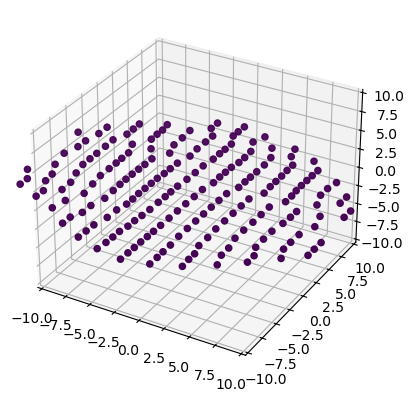

In [110]:
# make 3d scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
i = -1
ax.scatter(all_poss[i, :, 0], all_poss[i, :, 1], all_poss[i, :, 2], c=elongated_cells)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
plt.show()

KeyboardInterrupt: 

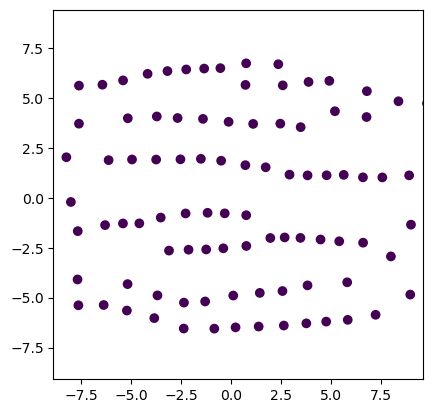

In [48]:
# make a ipython animation
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)
scatplot = ax.scatter(all_poss[0,:,0], all_poss[0,:,1], c = elongated_cells)

plt.axis('square')


def update_plot(i, all_poss, scatplot):
    scatplot.set_offsets(all_poss[i])

    # fig.canvas.update()
    fig.canvas.flush_events()

    return scatplot,

ani = animation.FuncAnimation(fig, update_plot, frames=rlen(all_poss)[::4], fargs=(all_poss, scatplot), interval=50, blit=True)

HTML(ani.to_jshtml())



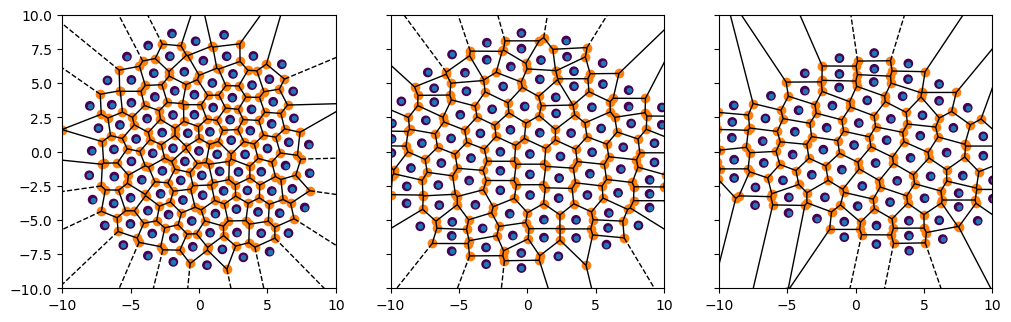

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12,5),  sharey=True) 



axind = 0
for frame_id in [0, 1000,-1]:
    make_voronoi(axs[axind], frame_id, all_poss, elongated_cells)

    axind += 1


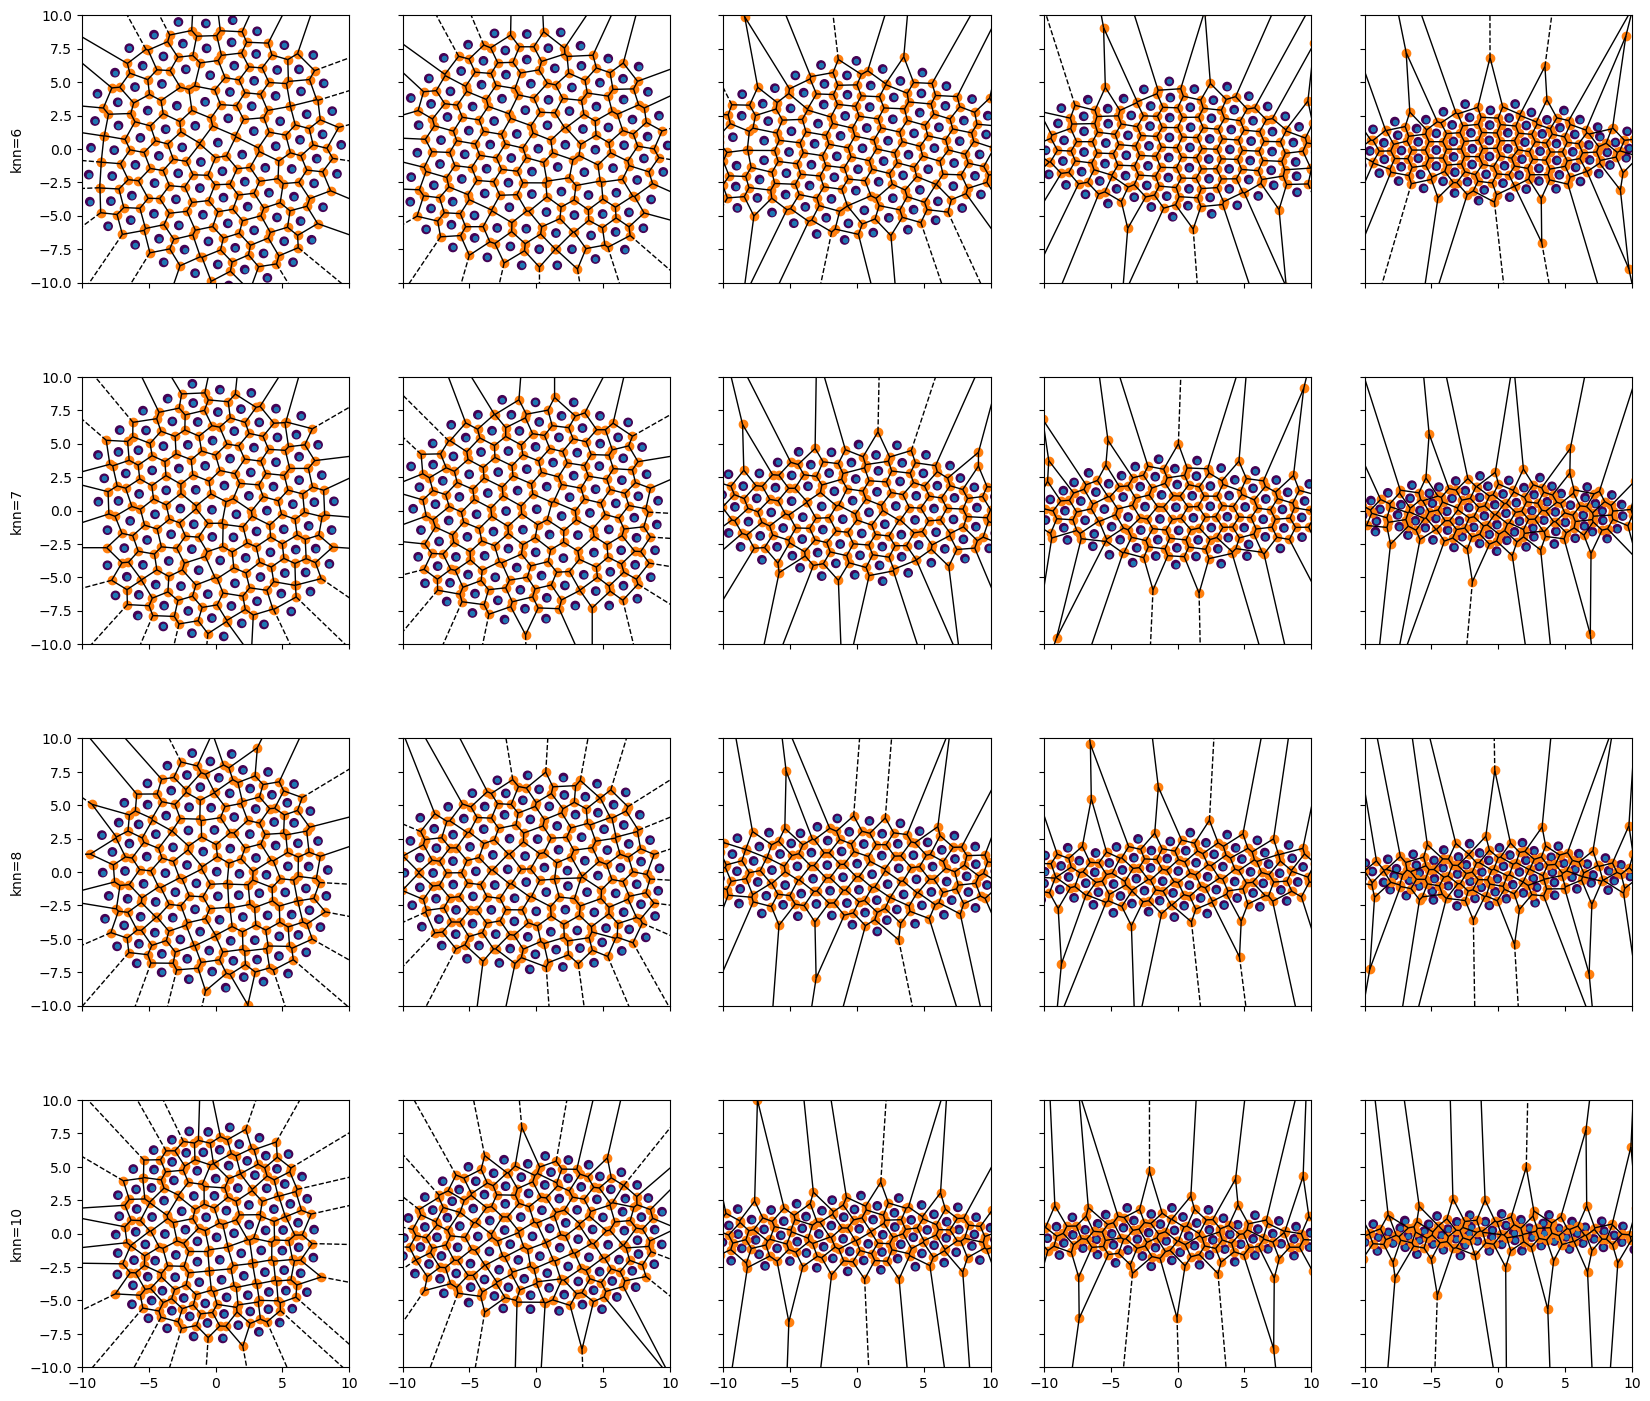

In [203]:
fig, axs = plt.subplots(4, 5, figsize=(20, 18),  sharey=True, sharex=True)

mksim = lambda p,  cutoff_knn : Simulation(10, 2001, eq_poss, p,  cutoff_knn)

for knnind, knn in enumerate([6, 7, 8, 10,]):
    mksim2 = lambda p: Simulation(10, 5001, eq_poss, p,  (4, knn))
    axs2 = axs[knnind]
    axs2[0].set_ylabel(f"knn={knn}")
    for axind, p in enumerate([1., 1.1, 1.3, 1.5, 2.]):
        sim = mksim2(p)
        sim.run()

        all_poss = sim.all_poss.detach().numpy()
        elongated_cells = sim.elongated_cells.numpy()
        qs = sim.cell_qs.detach().numpy()

        make_voronoi(axs2[axind], -1, all_poss, elongated_cells)



In [191]:
axs[0,0].set_ylabel("knn=6")
axs[1,0].set_ylabel("knn=8")
axs[2,0].set_ylabel("knn=10")
axs[3,0].set_ylabel("knn=12")

plt.show()